# 🧩 02 - Preprocesado + Modelado

Este notebook descarga los datos de la competencia, aplica el preprocesado basado en las decisiones de `01_exploración.ipynb`, entrena un **RandomForestClassifier**, genera `my_submission.csv` con el formato requerido (`ID,RENDIMIENTO_GLOBAL`)

**Notas**
- Revisa y ajusta las listas `drop_cols`, `ordinal_cols` y `num_impute_cols` hechas en `01_exploración.ipynb` se hicieron.


In [1]:
# 0) Librerías y configuración
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import joblib

pd.set_option('display.max_columns', 200)
RSEED = 42


In [2]:
# 1) Descargar datos desde Kaggle (requiere kaggle.json en el directorio)
os.environ['KAGGLE_CONFIG_DIR'] = '.'
# cambiar permisos (en algunos entornos es necesario)
!chmod 600 ./kaggle.json

# descargar (comenta la línea si ya tienes los archivos)
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

# descomprimir si hay ZIP(s)
!unzip -o udea*.zip > /dev/null || true

# listar archivos para confirmar
print('Contenido del directorio:')
!ls -la


  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.33GB/s]
Contenido del directorio:
total 233360
drwxr-xr-x 1 root root      4096 Oct 31 05:10 .
drwxr-xr-x 1 root root      4096 Oct 31 05:09 ..
drwxr-xr-x 4 root root      4096 Oct 29 13:38 .config
-rw------- 1 root root        76 Oct 31 05:10 kaggle.json
drwxr-xr-x 1 root root      4096 Oct 29 13:38 sample_data
-rw-r--r-- 1 root root   4716673 Sep 16 01:46 submission_example.csv
-rw-r--r-- 1 root root  59185238 Sep 16 01:46 test.csv
-rw-r--r-- 1 root root 143732437 Sep 16 01:46 train.csv
-rw-r--r-- 1 root root  31301114 Sep 16 01:46 udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip


In [12]:
# 2) Cargar train y test
train_path = 'train.csv'
test_path = 'test.csv'

assert os.path.exists(train_path), f"{train_path} no encontrado. Asegúrate de descargar y descomprimir los datos."
assert os.path.exists(test_path), f"{test_path} no encontrado. Asegúrate de descargar y descomprimir los datos."

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print('Train shape:', train.shape)
print('Test shape:', test.shape)
train.head()

# ======================================================
#  Agrupar categorías poco frecuentes en programas académicos
# ======================================================

top_programas = df_train["E_PRGM_ACADEMICO"].value_counts().nlargest(20).index
df_train.loc[~df_train["E_PRGM_ACADEMICO"].isin(top_programas), "E_PRGM_ACADEMICO"] = "otros"
df_test.loc[~df_test["E_PRGM_ACADEMICO"].isin(top_programas), "E_PRGM_ACADEMICO"] = "otros"

print(" Programas poco frecuentes agrupados en la categoría 'otros'")

# Nueva variable: promedio de los indicadores (más representativa)
train["INDICADORES_PROM"] = train[["INDICADOR_1", "INDICADOR_2", "INDICADOR_3", "INDICADOR_4"]].mean(axis=1)
test["INDICADORES_PROM"] = test[["INDICADOR_1", "INDICADOR_2", "INDICADOR_3", "INDICADOR_4"]].mean(axis=1)

print(" Nueva feature creada: INDICADORES_PROM")

# Promedio de educación de los padres (como texto combinado)
df_train["PROM_EDUC_PADRES"] = df_train["F_EDUCACIONPADRE"].astype(str) + "_" + df_train["F_EDUCACIONMADRE"].astype(str)
df_test["PROM_EDUC_PADRES"] = df_test["F_EDUCACIONPADRE"].astype(str) + "_" + df_test["F_EDUCACIONMADRE"].astype(str)

# Combinación de estrato con posesión de automóvil
df_train["ESTRATO_AUTOLAV"] = df_train["F_ESTRATOVIVIENDA"].astype(str) + "_" + df_train["F_TIENEAUTOMOVIL"].astype(str)
df_test["ESTRATO_AUTOLAV"] = df_test["F_ESTRATOVIVIENDA"].astype(str) + "_" + df_test["F_TIENEAUTOMOVIL"].astype(str)

print(" Nuevas features creadas: PROM_EDUC_PADRES y ESTRATO_AUTOLAV")




Train shape: (692500, 21)
Test shape: (296786, 20)
 Programas poco frecuentes agrupados en la categoría 'otros'
 Nueva feature creada: INDICADORES_PROM
 Nuevas features creadas: PROM_EDUC_PADRES y ESTRATO_AUTOLAV


In [13]:
# 3) Primer vistazo: columnas, tipos, nulos
print('Columns:', list(train.columns))
print('\nNulos por columna (train):')
print(train.isna().sum().sort_values(ascending=False).head(40))


Columns: ['ID', 'PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4', 'INDICADORES_PROM']

Nulos por columna (train):
F_TIENEAUTOMOVIL               43623
F_TIENELAVADORA                39773
F_TIENECOMPUTADOR              38103
F_ESTRATOVIVIENDA              32137
E_HORASSEMANATRABAJA           30857
F_TIENEINTERNET                26629
F_TIENEINTERNET.1              26629
F_EDUCACIONMADRE               23664
F_EDUCACIONPADRE               23178
E_PAGOMATRICULAPROPIO           6498
E_VALORMATRICULAUNIVERSIDAD     6287
E_PRGM_DEPARTAMENTO                0
ID                                 0
PERIODO_ACADEMICO                  0
E_PRGM_AC

## Decisiones aplicadas (puedes ajustar)
- Eliminar columnas con muchos NaN: `PoolQC`, `MiscFeature`, `Alley`, `Fence` (si existen).  
- Imputar numéricas por mediana (por ejemplo `LotFrontage`, `MasVnrArea` si existen).  
- Imputar categóricas con `'Missing'`.  
- Mapear variables ordinales con `qual_map`.  
- One-hot para categóricas restantes.  
- Feature engineering: `TotalSF`, `TotalPorch`, `HouseAge`, `RemodAge`.  
- Escalado con `StandardScaler`.  
- Modelo: `RandomForestClassifier` (guardado como `rf_model.joblib`).


In [14]:
# 4) Copiar y preparar dataframes (evitar cambios in-place peligrosos)
df_train = train.copy()
df_test = test.copy()


In [15]:
# 5) Columnas a eliminar (ajusta si no existen)
drop_cols = ['PoolQC','MiscFeature','Alley','Fence']
drop_cols = [c for c in drop_cols if c in df_train.columns]
print('Drop columns (if present):', drop_cols)
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])


Drop columns (if present): []


In [16]:
# 6) Reglas para garage/basement (crea indicadores y rellena con 0 en campos numéricos si aplica)
garage_cols = ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','GarageArea','GarageCars']
bsmt_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','TotalBsmtSF','BsmtUnfSF','BsmtFullBath','BsmtHalfBath']

for c in garage_cols:
    if c in df_train.columns:
        df_train[f'{c}_missing'] = df_train[c].isna().astype(int)
        if c in df_test.columns:
            df_test[f'{c}_missing'] = df_test[c].isna().astype(int)

for c in bsmt_cols:
    if c in df_train.columns:
        df_train[f'{c}_missing'] = df_train[c].isna().astype(int)
        if c in df_test.columns:
            df_test[f'{c}_missing'] = df_test[c].isna().astype(int)

# Rellenar GarageCars/GarageArea/TotalBsmtSF en test y train si existen
for col in ['GarageCars','GarageArea','TotalBsmtSF']:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna(0)
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna(0)


In [17]:
# 7) Imputación numérica por mediana (define las columnas que te interesen)
num_impute_cols = [c for c in ['LotFrontage','MasVnrArea'] if c in df_train.columns]
from sklearn.impute import SimpleImputer
if num_impute_cols:
    num_imputer = SimpleImputer(strategy='median')
    df_train[num_impute_cols] = num_imputer.fit_transform(df_train[num_impute_cols])
    df_test[num_impute_cols] = num_imputer.transform(df_test[num_impute_cols])
    joblib.dump(num_imputer, 'num_imputer.joblib')
    print('Num imputer saved.')
else:
    print('No numeric impute cols found in dataset.')


No numeric impute cols found in dataset.


In [18]:
# 8) Imputación categórica: rellenar con 'Missing'
cat_cols_train = df_train.select_dtypes(include=['object']).columns.tolist()
cat_cols_test = df_test.select_dtypes(include=['object']).columns.tolist()
print('Categorical cols train sample:', cat_cols_train[:20])

for c in cat_cols_train:
    df_train[c] = df_train[c].fillna('Missing')
for c in cat_cols_test:
    df_test[c] = df_test[c].fillna('Missing')


Categorical cols train sample: ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL']


In [20]:
# 9) Mapear variables ordinales (ajusta la lista si tu dataset usa otros nombres)
qual_map = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'Missing':0}
ordinal_cols = [c for c in ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond'] if c in df_train.columns]

for c in ordinal_cols:
    df_train[c] = df_train[c].map(qual_map).fillna(0).astype(int)
    if c in df_test.columns:
        df_test[c] = df_test[c].map(qual_map).fillna(0).astype(int)

print('Ordinal cols mapped:', ordinal_cols)


Ordinal cols mapped: []


In [21]:
# 10) Codificación categórica con OrdinalEncoder (reemplazo del One-Hot)
from sklearn.preprocessing import OrdinalEncoder
import joblib

# Detectar columnas categóricas (todas las E_ y F_)
cat_cols = [c for c in df_train.columns if c.startswith(("E_", "F_"))]

print("Columnas categóricas detectadas:", len(cat_cols))

# Crear y aplicar el codificador
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Ajustar en train y transformar test
df_train[cat_cols] = encoder.fit_transform(df_train[cat_cols])
df_test[cat_cols] = encoder.transform(df_test[cat_cols])

# Guardar el encoder por si lo necesitas después
joblib.dump(encoder, "ordinal_encoder.joblib")
print("Codificación Ordinal aplicada y guardada en 'ordinal_encoder.joblib'")

# Mostrar una muestra para verificar
df_train[cat_cols].head()

Columnas categóricas detectadas: 14
Codificación Ordinal aplicada y guardada en 'ordinal_encoder.joblib'


,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE
0,300.0,4.0,3.0,3.0,2.0,2.0,12.0,2.0,2.0,0.0,1.0,2.0,2.0,6.0
1,249.0,3.0,1.0,0.0,2.0,1.0,11.0,2.0,1.0,0.0,1.0,2.0,1.0,12.0
2,819.0,4.0,1.0,5.0,2.0,2.0,9.0,2.0,1.0,0.0,1.0,1.0,2.0,9.0
3,14.0,26.0,2.0,0.0,3.0,2.0,5.0,2.0,1.0,0.0,1.0,2.0,2.0,9.0
4,907.0,1.0,1.0,2.0,2.0,2.0,7.0,2.0,2.0,0.0,1.0,2.0,2.0,7.0


In [22]:
# 11) Feature engineering (adaptado al dataset de desempeño académico)
# En este caso, las columnas originales no tienen métricas numéricas de superficie o edad.
# Si más adelante decides crear indicadores derivados, agrégalos aquí.

# Ejemplo simple: crear proporciones o variables sintéticas (opcional)
if 'E_HORASSEMANATRABAJA' in df_train.columns and 'E_VALORMATRICULAUNIVERSIDAD' in df_train.columns:
    # Relación entre horas trabajadas y valor de matrícula (solo como ejemplo)
    df_train['TRABAJO_MATRICULA_RATIO'] = df_train['E_HORASSEMANATRABAJA'] / (df_train['E_VALORMATRICULAUNIVERSIDAD'] + 1)
    df_test['TRABAJO_MATRICULA_RATIO'] = df_test['E_HORASSEMANATRABAJA'] / (df_test['E_VALORMATRICULAUNIVERSIDAD'] + 1)
    print("Nueva feature creada: TRABAJO_MATRICULA_RATIO")
else:
    print("No se generaron nuevas features (no aplican columnas tipo superficie o edad).")

# Mostrar muestra de columnas finales
df_train.head()


Nueva feature creada: TRABAJO_MATRICULA_RATIO


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4,INDICADORES_PROM,TRABAJO_MATRICULA_RATIO
0,904256,20212,300.0,4.0,3.0,3.0,2.0,2.0,12.0,2.0,2.0,0.0,1.0,2.0,2.0,6.0,medio-alto,0.322,0.208,0.310,0.267,0.27675,0.75
1,645256,20212,249.0,3.0,1.0,0.0,2.0,1.0,11.0,2.0,1.0,0.0,1.0,2.0,1.0,12.0,bajo,0.311,0.215,0.292,0.264,0.27050,0.00
2,308367,20203,819.0,4.0,1.0,5.0,2.0,2.0,9.0,2.0,1.0,0.0,1.0,1.0,2.0,9.0,bajo,0.297,0.214,0.305,0.264,0.27000,2.50
3,470353,20195,14.0,26.0,2.0,0.0,3.0,2.0,5.0,2.0,1.0,0.0,1.0,2.0,2.0,9.0,alto,0.485,0.172,0.252,0.190,0.27475,0.00
4,989032,20212,907.0,1.0,1.0,2.0,2.0,2.0,7.0,2.0,2.0,0.0,1.0,2.0,2.0,7.0,medio-bajo,0.316,0.232,0.285,0.294,0.28175,1.00


In [23]:
# 12) Preparar X and y (codificar target con LabelEncoder para manejar etiquetas textuales)
target_col = 'RENDIMIENTO_GLOBAL'
assert target_col in df_train.columns, f"Target column {target_col} not found in train. Revisa el nombre exacto."

X = df_train.drop(columns=[target_col]).copy()
y = df_train[target_col].copy()

# Ensure test has ID column saved separately
id_col = 'ID'
assert id_col in df_test.columns, f"ID column '{id_col}' not found in test.csv"
test_ids = df_test[id_col].values
X_test = df_test.drop(columns=[id_col]).copy()

print('X shape:', X.shape, 'y shape:', y.shape, 'X_test shape:', X_test.shape)


X shape: (692500, 22) y shape: (692500,) X_test shape: (296786, 21)


In [24]:
# 13) Rellenar cualquier NaN restante en variables numéricas (asegurando coherencia entre X y X_test)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Excluir columnas que no estén en ambos datasets o que sean identificadores
num_cols = [c for c in num_cols if c in X_test.columns and c.lower() != 'id']

print(f"Columnas numéricas a imputar ({len(num_cols)}):", num_cols[:10])

num_imputer2 = SimpleImputer(strategy='median')

X[num_cols] = num_imputer2.fit_transform(X[num_cols])
X_test[num_cols] = num_imputer2.transform(X_test[num_cols])

joblib.dump(num_imputer2, 'num_imputer_final.joblib')
print('Final numeric imputer saved.')


Columnas numéricas a imputar (21): ['PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL']
Final numeric imputer saved.


In [25]:
# 14) Encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Classes:', list(le.classes_))
joblib.dump(le, 'label_encoder.joblib')


Classes: ['alto', 'bajo', 'medio-alto', 'medio-bajo']


['label_encoder.joblib']

In [26]:
# 15) Escalado de características numéricas (asegurando consistencia entre X y X_test)

# Seleccionamos columnas numéricas comunes
scale_cols = [c for c in X.select_dtypes(include=[np.number]).columns if c in X_test.columns and c.lower() != 'id']

print(f"Columnas numéricas a escalar ({len(scale_cols)}):", scale_cols[:10])

scaler = StandardScaler()
X[scale_cols] = scaler.fit_transform(X[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

joblib.dump(scaler, 'scaler_final.joblib')
print('Scaler guardado. Número de columnas escaladas:', len(scale_cols))


Columnas numéricas a escalar (21): ['PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL']
Scaler guardado. Número de columnas escaladas: 21


In [27]:
# ======================================================
# 16) Entrenamiento con XGBoost optimizado
# ======================================================

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import joblib

# Separar target y features
y = df_train["RENDIMIENTO_GLOBAL"].copy()
X = df_train.drop(columns=["RENDIMIENTO_GLOBAL"]).copy()

# Codificar las etiquetas del target
le = LabelEncoder()
y_enc = le.fit_transform(y)
joblib.dump(le, "label_encoder.joblib")

# Asegurar que 'ID' no esté en las features
if "ID" in X.columns:
    X = X.drop(columns=["ID"])

# Alinear columnas entre train y test
missing_in_test = set(X.columns) - set(df_test.columns)
missing_in_train = set(df_test.columns) - set(X.columns)
if missing_in_test or missing_in_train:
    print(" Ajustando columnas para coincidencia...")
    for col in missing_in_test:
        df_test[col] = 0
    for col in missing_in_train:
        X[col] = 0

X_test = df_test[X.columns].copy()

print(" Entrenando modelo XGBoost optimizado...")

clf = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RSEED,
    tree_method="hist",
    verbosity=1
)

clf.fit(X, y_enc)
joblib.dump(clf, "xgb_model.joblib")

print("Modelo XGBoost entrenado y guardado como xgb_model.joblib")

 Ajustando columnas para coincidencia...
🚀 Entrenando modelo XGBoost optimizado...
Modelo XGBoost entrenado y guardado como xgb_model.joblib


In [28]:
# ======================================================
# 17) Predicciones sobre test y generación de submission
# ======================================================

# Extraer los IDs del conjunto de test
test_ids = df_test["ID"].values

print("Generando predicciones sobre el conjunto de test...")

# Alinear columnas con las usadas durante el entrenamiento
X_test_aligned = X_test.reindex(columns=X.columns, fill_value=0)

# Predecir
preds_enc = clf.predict(X_test_aligned)
preds = le.inverse_transform(preds_enc)

# Crear el DataFrame de submission
submission = pd.DataFrame({
    "ID": test_ids,
    "RENDIMIENTO_GLOBAL": preds
})

submission.to_csv("my_submission.csv", index=False)
print("Archivo 'my_submission.csv' generado correctamente.")
display(submission.head())

Generando predicciones sobre el conjunto de test...
Archivo 'my_submission.csv' generado correctamente.


,ID,RENDIMIENTO_GLOBAL
0,550236,alto
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo


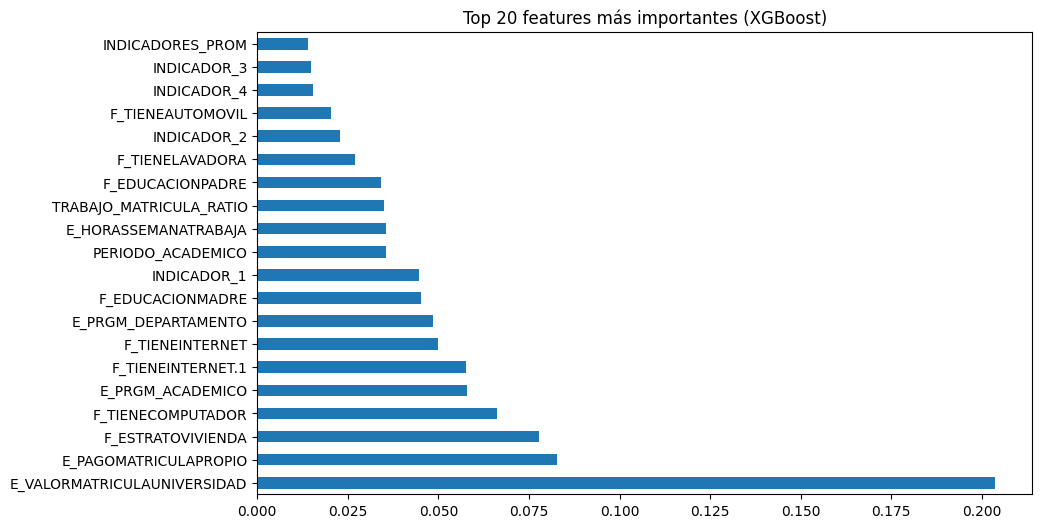

In [29]:
# ======================================================
# 18) Importancia de las variables (feature importance)
# ======================================================
import pandas as pd
import matplotlib.pyplot as plt

try:
    importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features = importances.head(20)

    plt.figure(figsize=(10,6))
    top_features.plot(kind='barh')
    plt.title("Top 20 features más importantes (XGBoost)")
    plt.show()
except Exception as e:
    print(" No se pudo calcular la importancia de las variables:", e)

In [30]:
# Comando para enviar

!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f my_submission.csv -m "RF submit from notebook"

100% 4.05M/4.05M [00:00<00:00, 13.5MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia

---

## Notas finales
- El notebook realiza un pipeline básico pero robusto: descarga → preprocesado → modelado → predicción → creación de submission.  
- Ajusta listas (`drop_cols`, `ordinal_cols`, `num_impute_cols`) si tu análisis de `01_exploración.ipynb` tenía decisiones diferentes.  
- Para ejecutar el envío a Kaggle automáticamente, quita el comentario de la última línea (`kaggle competitions submit ...`).  
- Si quieres, puedo intentar ejecutar este notebook en el entorno actual (si Kaggle API y archivos están disponibles) y devolverte `my_submission.csv` y los artefactos (`rf_model.joblib`, `scaler_final.joblib`, etc.).